In [ ]:

!pip install libpysal
!pip install geopandas
!pip install fiona
!pip install contextily
!pip install pyprobs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 19.1 MB/s eta 0:00:00


In [ ]:
import geopandas as gp
import libpysal as psl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from copy import copy, deepcopy
import time
from pylab import *
from IPython import display
from contextily import add_basemap
import math
from pyprobs import Probability as pr
import random
import seaborn as sns

In [ ]:
def mapinit():
  global gdf, gdw
  world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
  cities = gp.read_file(gp.datasets.get_path('naturalearth_cities'))

  gdf_mask = gp.read_file(
      gp.datasets.get_path("naturalearth_lowres")
  )

  gdaf = gp.read_file(
      gp.datasets.get_path("naturalearth_cities")
      ,mask=gdf_mask[gdf_mask.continent=="Africa"]
  )
  gdeu = gp.read_file(
      gp.datasets.get_path("naturalearth_cities")
      ,mask=gdf_mask[gdf_mask.continent=="Europe"]
  )
  gdas = gp.read_file(
      gp.datasets.get_path("naturalearth_cities")
      ,mask=gdf_mask[gdf_mask.continent=="Asia"]
  )
  cframes = [gdaf, gdeu, gdas]
  gdf = pd.concat(cframes)

  gdw = gp.read_file(
      gp.datasets.get_path("naturalearth_lowres")
  )

  gdw.drop(gdw[gdw['continent'] == 'North America'].index, inplace=True)
  gdw.drop(gdw[gdw['continent'] == 'Oceania'].index, inplace=True)
  gdw.drop(gdw[gdw['continent'] == 'South America'].index, inplace=True)
  gdw.drop(gdw[gdw['continent'] == 'Antarctica'].index, inplace=True)
  gdw.drop(gdw[gdw['continent'] == 'Australia'].index, inplace=True)
  gdw.drop(gdw[gdw['continent'] == 'Seven seas (open ocean)'].index, inplace=True)
  gdw.drop(gdw[gdw['name'] == 'Iceland'].index, inplace=True)
  gdw.drop(gdw[gdw['name'] == 'Russia'].index, inplace=True)
  gdw.drop(gdw[gdw['name'] == 'France'].index, inplace=True)

  df = pd.DataFrame(data=gdf)
  names = df['name'].to_numpy()
  gdf['x'] = None
  gdf['y'] = None
  gdf['x'] = gdf.geometry.apply(lambda x: x.x)
  gdf['y'] = gdf.geometry.apply(lambda y: y.y)
  coordinate_list = [(x,y) for x,y in zip(gdf.x , gdf.y)]
  coordinate_dict = dict(zip(names, coordinate_list))

In [ ]:
def initialize():
  global G, nextg, prev, worldpop, pos, worldage, ex, gdf, edgewidths, gr, cc, years
  mapinit()

  #parameters
  ex = 0.5  # decides growth probability
  gr = 1.4  # growth rate
  dist = 20 # max edge length
  cc = 500  # carrying capacity

  coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))

  dist = psl.weights.DistanceBand.from_array(coordinates, threshold=dist)

  G = dist.to_networkx()

  pos = dict(zip(G.nodes, coordinates))

  for n in G.nodes:
    G.nodes[n]['pop'] = 0

  G.nodes[52]['pop'] = 10

  worldage = 200
  worldpop = []
  years = []

  edgewidths = []
  for i in G.nodes:
      edgewidths.append(0)

  nextg = G.copy()



In [ ]:
def initialize_with_parameters(ex, gr, dist, cc):
  global G, nextg, prev, worldpop, pos, worldage, gdf, edgewidths, years
  mapinit()

  coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))

  dist = psl.weights.DistanceBand.from_array(coordinates, threshold=dist)

  G = dist.to_networkx()

  pos = dict(zip(G.nodes, coordinates))

  for n in G.nodes:
    G.nodes[n]['pop'] = 0

  G.nodes[52]['pop'] = 10

  worldage = 200
  worldpop = []
  years = []

  edgewidths = []
  for i in G.nodes:
      edgewidths.append(0)

  nextg = G.copy()

In [ ]:
def update():
  global G, nextg, prev, pos, worldage, worldstring, ex, edgewidths, worldpop, gr, cc, years
  curprev = 0
  nextg = deepcopy(G)

  for a in G.nodes:
    if G.nodes[a]['pop'] > 0:
      if G.nodes[a]['pop'] >= cc:
        nextg.nodes[a]['pop'] = int(random.uniform(G.nodes[a]['pop'], (G.nodes[a]['pop'] * gr)))
        overflow = nextg.nodes[a]['pop'] - cc
        for b in G.neighbors(a):
          if pr.prob((ex)/G.degree(a)):
            nextg.nodes[b]['pop'] += overflow/G.degree(a)
        nextg.nodes[a]['pop'] = cc
      else:
        nextg.nodes[a]['pop'] = int(random.uniform(G.nodes[a]['pop'], (G.nodes[a]['pop'] * gr)))
        if nextg.nodes[a]['pop'] >= 20:
          for b in G.neighbors(a):
            if pr.prob((ex)/G.degree(a)):
              nextg.nodes[b]['pop'] +=3

  edgewidths = []
  for i in G.nodes:
    if G.nodes[i]['pop'] > 30:
      edgewidths.append(math.log10((G.nodes[i]['pop']+1))/20)
    else:
      edgewidths.append(0)

  sum = 0
  for i in G.nodes:
    sum += G.nodes[i]['pop']
  worldpop.append(sum)

  worldage -= 2
  worldstring = 'World Age: ' + str(worldage) + " Ka    World Population: " + str(int(worldpop[-1]))
  pops = list(nx.get_node_attributes(nextg, "pop").values())

  years.append(worldage - 40)

  G = deepcopy(nextg)



In [ ]:
def collect_data():
    global worldpop, worldage
    total_pop = worldpop[-1]

    # Other relevant metrics

    return total_population, average_age

In [ ]:
def observe():
  global G, nextg, prev, labels_dict, pops, pos, worldstring, ex, gdw, edgewidths

  gdw.plot(color='white', edgecolor='black', linewidth=0.3)
  plt.xlabel(worldstring, loc='left')

  nx.draw_networkx_nodes(G, pos, node_size=[math.log2(G.nodes[i]['pop']+1) for i in G.nodes])
  nx.draw_networkx_edges(G, pos, width=edgewidths, style='dashed')

  plt.show()

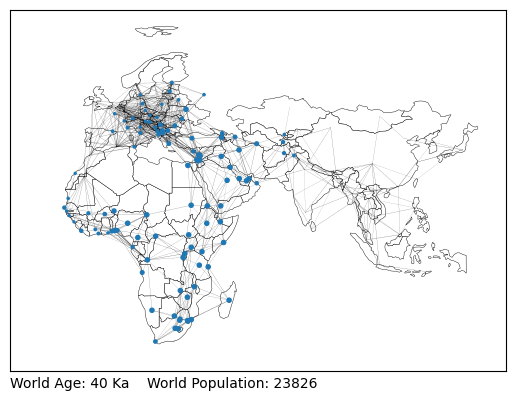

In [ ]:
initialize()
for i in range(80):
  update()
  observe()
  display.clear_output(wait=True)
  time.sleep(0)


In [ ]:
ex_range = [0.1, 0.5, 0.9]
gr_range = [1.0, 1.4, 1.8]
dist_range = [10, 20, 30]
cc_range = [200, 500, 800]

worldpops=[]
# Nested loops to iterate over parameter combinations
for ex in ex_range:
    for gr in gr_range:
        for dist in dist_range:
            for cc in cc_range:
                # Initialize simulation with current parameter values
                initialize_with_parameters(ex, gr, dist, cc)

                # Run simulation for a certain number of iterations
                for _ in range(80):
                    update()

                    # Collect data you want to visualize
                    worldpops.append(worldpop)

<ipython-input-3-82ff5ef59afd>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
<ipython-input-3-82ff5ef59afd>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities = gp.read_file(gp.datasets.get_path('naturalearth_cities'))
<ipython-input-3-82ff5ef59afd>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gp.datasets.get_path("naturalearth_lowres")
<ipython-input-3-82ff5ef59afd>:11: FutureWarning: The g

In [ ]:
for i, worldpop_data in enumerate(worldpops):
    plt.scatter(years, worldpop_data, label=f'Parameter Set {i+1}')

# Add labels and legend
plt.xlabel("Ka Elapsed")
plt.ylabel("Population")
plt.legend()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 597x135751 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

Text(0, 0.5, 'Population')

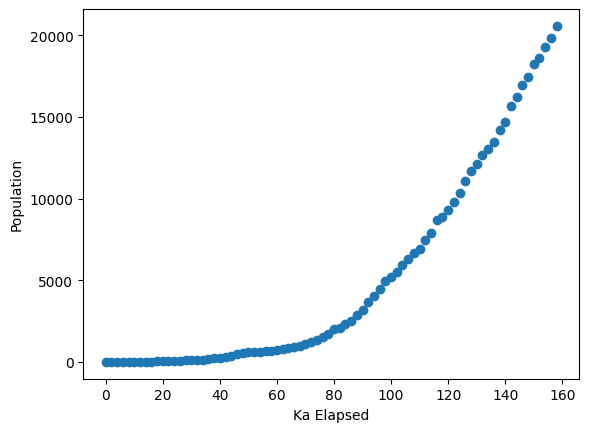

In [ ]:
years.reverse()
plt.scatter(years, worldpop)
plt.xlabel("Ka Elapsed")
plt.ylabel("Population")